In [1]:
import os
from pathlib import Path
script_dir = os.path.dirname(Path().resolve())
os.chdir(script_dir)
os.makedirs(os.path.join(script_dir, 'output'), exist_ok=True)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

from src.recursive_token_chunker import RecursiveTokenChunker
from src.Embedding import GPTEmbedding
from src.EvaluationPipeline import EvaluationPipeline
from src.Utils import Utils

In [3]:
gpt_df = pd.read_csv(os.path.join('output', 'gpt_results.csv'))

In [4]:
gpt_df 

,chunker,chunk_size,overlap_size,top_k,iou_scores,recall_scores,precision_scores
0,fixed-size,800,400,5,0.013998,0.940112,0.013999
1,fixed-size,800,400,10,0.007425,0.998593,0.007425
2,fixed-size,800,400,Min,0.029029,0.770736,0.029069
3,recursive,800,400,5,0.016293,0.920350,0.016294
4,recursive,800,400,10,0.008593,0.982850,0.008593
5,recursive,800,400,Min,0.037936,0.721123,0.037941
6,fixed-size,800,200,5,0.014207,0.940149,0.014209
7,fixed-size,800,200,10,0.007567,0.994837,0.007567
8,fixed-size,800,200,Min,0.034050,0.605602,0.034101
9,recursive,800,200,5,0.016928,0.955072,0.016928


In [5]:
filtered_gpt_df = gpt_df.groupby(['top_k']).agg({'precision_scores': 'mean', 'recall_scores': 'mean'}).reset_index()
filtered_gpt_df

,top_k,precision_scores,recall_scores
0,10,0.018041,0.987010
1,5,0.034108,0.938635
2,Min,0.099740,0.682987


The top_k parameter once again demonstrates precision-recall tradeoff, just like in sentence-transformer evaluation.

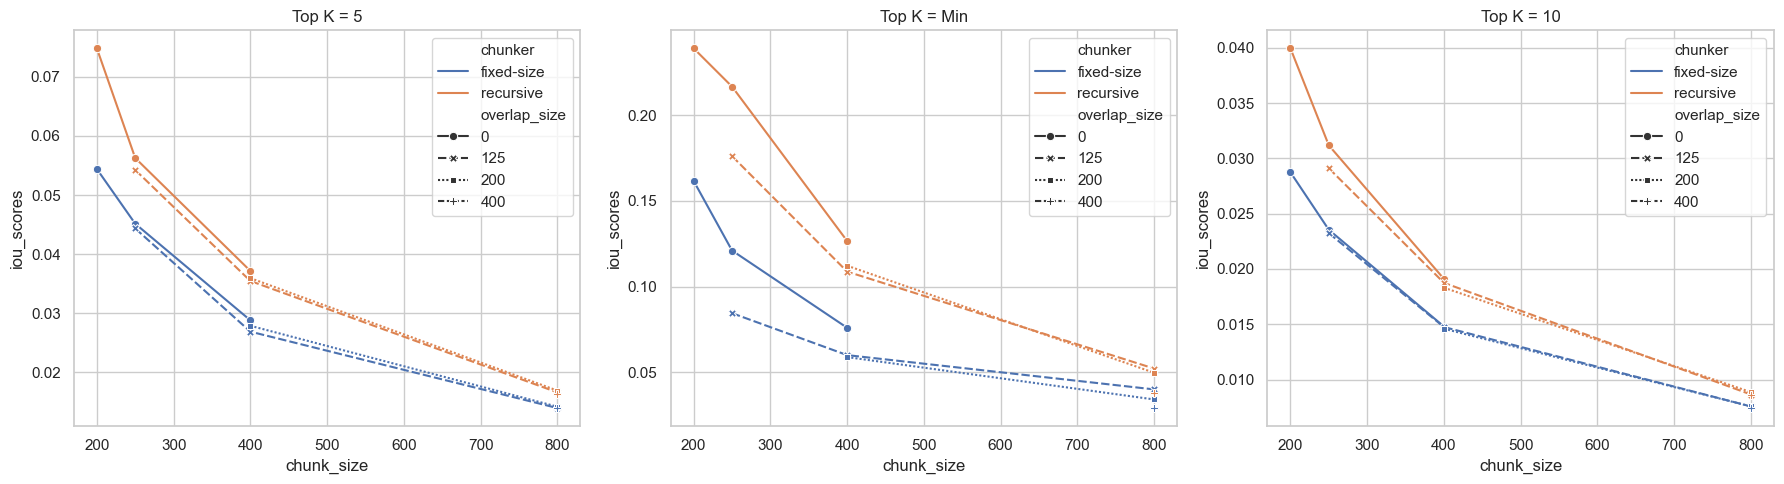

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

sns.lineplot(
    data=gpt_df[gpt_df['top_k'] == '5'],
    x='chunk_size',
    y='iou_scores',
    hue='chunker',
    style='overlap_size',
    markers=True,
    ax=ax1
)
ax1.set_title('Top K = 5')

sns.lineplot(
    data=gpt_df[gpt_df['top_k'] == 'Min'],
    x='chunk_size',
    y='iou_scores',
    hue='chunker',
    style='overlap_size',
    markers=True,
    ax=ax2
)
ax2.set_title('Top K = Min')

sns.lineplot(
    data=gpt_df[gpt_df['top_k'] == '10'],
    x='chunk_size',
    y='iou_scores',
    hue='chunker',
    style='overlap_size',
    markers=True,
    ax=ax3
)
ax3.set_title('Top K = 10')

plt.tight_layout()

We can take the mean iou_score for every chunk_size and visualize it better.

<Axes: xlabel='chunk_size', ylabel='iou_scores'>

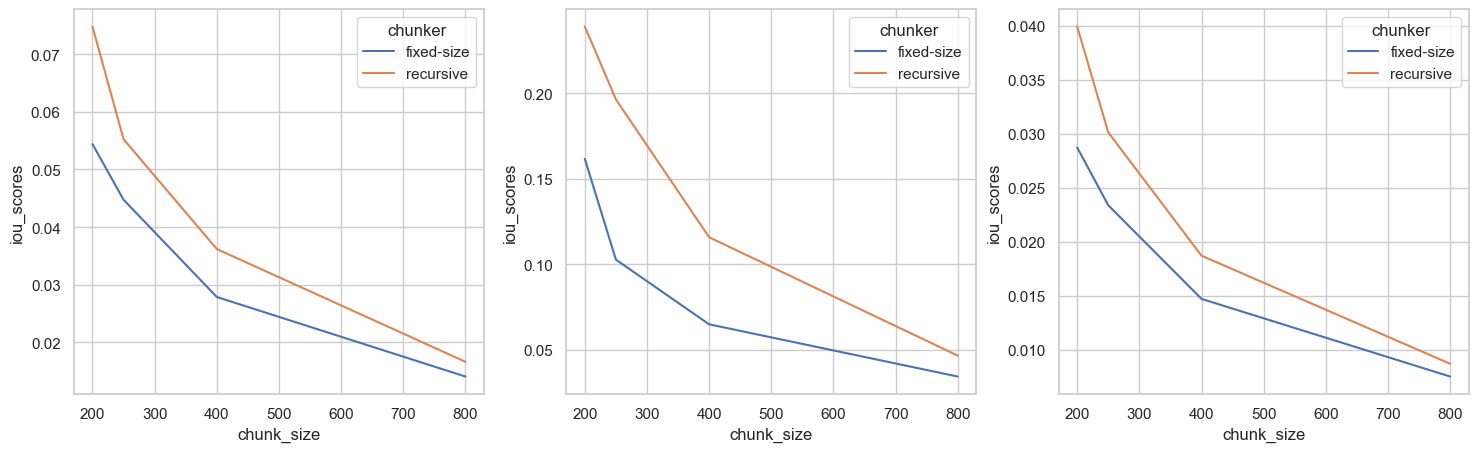

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
filtered_gpt_df = gpt_df.groupby(['chunker', 'chunk_size', 'top_k']).agg({'iou_scores': 'mean'}).reset_index()
sns.lineplot(data=filtered_gpt_df[filtered_gpt_df['top_k'] == '5'], x='chunk_size', y='iou_scores', hue='chunker', ax=ax1)
sns.lineplot(data=filtered_gpt_df[filtered_gpt_df['top_k'] == 'Min'], x='chunk_size', y='iou_scores', hue='chunker', ax=ax2)
sns.lineplot(data=filtered_gpt_df[filtered_gpt_df['top_k'] == '10'], x='chunk_size', y='iou_scores', hue='chunker', ax=ax3)

Again, iou_score decreases with increasing chunk_size.
Also, recursive chunking is still the best choice.

Let's extract the maximum values of recall, iou, and precision for each top_k configuration.

In [8]:
def max_values(df):
    max_recall = df.loc[df['recall_scores'].idxmax()]
    max_iou = df.loc[df['iou_scores'].idxmax()]
    max_precision = df.loc[df['precision_scores'].idxmax()]
    
    return max_recall, max_iou, max_precision

In [9]:
gpt_max_all = pd.DataFrame()

for k in ['5', '10', 'Min']:
    df = gpt_df[gpt_df['top_k'] == k]
    max_gpt_recall, max_gpt_iou, max_gpt_precision = max_values(df)
    
    gpt_max = pd.DataFrame([max_gpt_recall, max_gpt_iou, max_gpt_precision], 
                          index=['max-recall', 'max-iou', 'max-precision'])
    
    gpt_max_all = pd.concat([gpt_max_all, gpt_max], axis=0)
    
gpt_max_all

,chunker,chunk_size,overlap_size,top_k,iou_scores,recall_scores,precision_scores
max-recall,recursive,800,125,5,0.016630,0.968961,0.016630
max-iou,recursive,200,0,5,0.074812,0.941592,0.074931
max-precision,recursive,200,0,5,0.074812,0.941592,0.074931
max-recall,recursive,800,200,10,0.008861,1.000000,0.008861
max-iou,recursive,200,0,10,0.039945,0.974859,0.039956
max-precision,recursive,200,0,10,0.039945,0.974859,0.039956
max-recall,fixed-size,400,200,Min,0.058793,0.785202,0.059236
max-iou,recursive,200,0,Min,0.239104,0.685919,0.242697
max-precision,recursive,200,0,Min,0.239104,0.685919,0.242697


We can conduct few interesting configurations of hyperparameters:

#### Highest IoU/Precision Configuration
- Chunker: Recursive
- Chunk Size: 200
- Overlap Size: 0
- Top K: Min

#### Highest Recall Configuration
- Chunker: Recursive
- Chunk Size: 800
- Overlap Size: 200
- Top K: 10

#### Overall Well-Performing Configurations
##### Configuration 1
- Chunker: Recursive
- Chunk Size: 200
- Overlap Size: 0
- Top K: 5
##### Configuration 2
- Chunker: Recursive
- Chunk Size: 250
- Overlap Size: 125
- Top K: Min
##### Configuration 3
- Chunker: Recursive
- Chunk Size: 250
- Overlap Size: 0
- Top K: Min

Therefore, let's evaluate the performance of the well-performing configurations with reranker=True.

In [10]:
metrics_list = []

pipeline = EvaluationPipeline(RecursiveTokenChunker(chunk_size=200, chunk_overlap=0, length_function=Utils.cl100k_base_length), 
                              GPTEmbedding(), 
                              top_k=5, 
                              reranker=True)
metrics_list.append(pipeline.evaluate_retrievals('wikitexts', False))

pipeline = EvaluationPipeline(RecursiveTokenChunker(chunk_size=250, chunk_overlap=125, length_function=Utils.cl100k_base_length),
                              GPTEmbedding(),
                              top_k=5,
                              reranker=True)
metrics_list.append(pipeline.evaluate_retrievals('wikitexts', True))

pipeline = EvaluationPipeline(RecursiveTokenChunker(chunk_size=250, chunk_overlap=0, length_function=Utils.cl100k_base_length),
                              GPTEmbedding(),
                              top_k=5,
                              reranker=True)
metrics_list.append(pipeline.evaluate_retrievals('wikitexts', True))

df = pd.DataFrame(metrics_list, 
             index=['Recursive-200-0-5', 'Recursive-250-125-Min', 'Recursive-250-0-Min'])
df.to_csv(os.path.join('output', 'reranker_results.csv'), index=True)

Error during evaluation: Failed to perform chunking: Failed to load corpora or questions: Failed to locate questions file: No question .csv found.


NameError: name 'exit' is not defined

In [ ]:
df